# 3.2.6 나만의 데이터셋을 만들어 집값 예측하기

- 작성자: [김찬란](https://github.com/seriousran)

In [2]:
# 코드 3-34 패키지 임포트 및 주택가격 정보 읽어오기

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from keras import metrics
from keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/colab/dataset/"

df_ks_cn = pd.read_csv("/content/drive/My Drive/colab/dataset/house/경상남도_창녕군_개별주택가격정보_20190806.csv", encoding = "euc-kr")
df_dj_dg = pd.read_csv("/content/drive/My Drive/colab/dataset/house/대전광역시_동구_개별주택가격정보_20190719.csv", encoding = "euc-kr")
df_jr_wj = pd.read_csv("/content/drive/My Drive/colab/dataset/house/전라북도_완주군_개별주택가격정보_20191010.csv", encoding = "euc-kr")
df_jr_jj = pd.read_csv("/content/drive/My Drive/colab/dataset/house/전라북도_전주시_개별주택가격정보_20190508.csv", encoding = "euc-kr")
df_cc_cj = pd.read_csv("/content/drive/My Drive/colab/dataset/house/충청북도_충주시_개별주택가격정보_20190501.csv", encoding = "euc-kr")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fruit_1  fruit_2  house  new_training


In [3]:
# 코드 3-35 데이터 선별 및 통합

df_tmp = []
df_tmp_y = []
for idx, df in enumerate([df_ks_cn, df_dj_dg, df_jr_wj, df_jr_jj, df_cc_cj]):
  df_tmp.append(df.loc[:,['법정동코드', '법정동명', '지번', '특수지구분명', '토지대장면적', '산정대지면적', '건물전체연면적', '건물산정연면적', '표준지여부', '주택가격']])
df_train = pd.concat([df_tmp[0], df_tmp[1], df_tmp[2], df_tmp[3], df_tmp[4]])
df_train.head()

,법정동코드,법정동명,지번,특수지구분명,토지대장면적,산정대지면적,건물전체연면적,건물산정연면적,표준지여부,주택가격
0,4874025021,경상남도 창녕군 창녕읍 송현리,45-8,일반,610.0,610.0,93.15,93.15,N,97000000
1,4874025021,경상남도 창녕군 창녕읍 송현리,62-2,일반,270.0,270.0,51.57,51.57,N,51000000
2,4874025021,경상남도 창녕군 창녕읍 송현리,62-3,일반,476.0,376.0,81.58,81.58,N,88200000
3,4874025021,경상남도 창녕군 창녕읍 송현리,64-3,일반,415.0,415.0,135.85,135.85,N,110000000
4,4874025021,경상남도 창녕군 창녕읍 송현리,66-1,일반,533.0,47.0,28.76,28.76,N,6020000


In [4]:
# 코드 3-36 컬럼 이름 지정

df_train.columns = ['legal_code','legal_name','dist_num', 'is_special','land_area','counting_area', 'total_area', 'building_area', 'is_standard', 'price']
df_train.head()

,legal_code,legal_name,dist_num,is_special,land_area,counting_area,total_area,building_area,is_standard,price
0,4874025021,경상남도 창녕군 창녕읍 송현리,45-8,일반,610.0,610.0,93.15,93.15,N,97000000
1,4874025021,경상남도 창녕군 창녕읍 송현리,62-2,일반,270.0,270.0,51.57,51.57,N,51000000
2,4874025021,경상남도 창녕군 창녕읍 송현리,62-3,일반,476.0,376.0,81.58,81.58,N,88200000
3,4874025021,경상남도 창녕군 창녕읍 송현리,64-3,일반,415.0,415.0,135.85,135.85,N,110000000
4,4874025021,경상남도 창녕군 창녕읍 송현리,66-1,일반,533.0,47.0,28.76,28.76,N,6020000


In [5]:
# 코드 3-37 조건에 맞는 값의 개수 카운트

df_train[df_train['price'] == 0]['price'].value_counts()

0    1258
Name: price, dtype: int64

In [6]:
# 코드 3-38 집값이 0인 데이터 삭제

df_train = df_train.loc[(df_train['price']!=0)]
print(df_train.shape)

(134799, 10)


In [7]:
# 코드 3-39 지번을 나누어 칼럼으로 추가

df_train['dist_num_0']= df_train['dist_num'].str.split('-').str.get(0)
df_train['dist_num_1']= df_train['dist_num'].str.split('-').str.get(1)
df_train = df_train.drop(['dist_num'], axis=1)
df_train.head()

,legal_code,legal_name,is_special,land_area,counting_area,total_area,building_area,is_standard,price,dist_num_0,dist_num_1
0,4874025021,경상남도 창녕군 창녕읍 송현리,일반,610.0,610.0,93.15,93.15,N,97000000,45,8
1,4874025021,경상남도 창녕군 창녕읍 송현리,일반,270.0,270.0,51.57,51.57,N,51000000,62,2
2,4874025021,경상남도 창녕군 창녕읍 송현리,일반,476.0,376.0,81.58,81.58,N,88200000,62,3
3,4874025021,경상남도 창녕군 창녕읍 송현리,일반,415.0,415.0,135.85,135.85,N,110000000,64,3
4,4874025021,경상남도 창녕군 창녕읍 송현리,일반,533.0,47.0,28.76,28.76,N,6020000,66,1


In [8]:
# 코드 3-40 부분 지번의 값이 0인 데이터 찾기

df_train[df_train['dist_num_0'] == '0']
df_train[df_train['dist_num_1'] == '0']

,legal_code,legal_name,is_special,land_area,counting_area,total_area,building_area,is_standard,price,dist_num_0,dist_num_1


In [9]:
# 코드 3-41 결측값 계수-1

df_train['dist_num_0'].isna().value_counts()

False    89490
True     45309
Name: dist_num_0, dtype: int64

In [10]:
# 코드 3-42 결측값 계수-2

df_train['dist_num_1'].isna().value_counts()

False    69777
True     65022
Name: dist_num_1, dtype: int64

In [0]:
# 코드 3-43 결측값 채우고 검사

df_train['dist_num_0'] = df_train['dist_num_0'].fillna('0')
df_train['dist_num_1'] = df_train['dist_num_1'].fillna('0')

In [0]:
# 코드 3-44 특정 칼럼을 정수로 변환

df_train['dist_num_0']= df_train['dist_num_0'].astype(int)
df_train['dist_num_1']= df_train['dist_num_1'].astype(int)

In [0]:
# 코드 3-45 LabelEnocder를 이용한 인코딩

label_encoder_sp = LabelEncoder()
df_train['is_special'] = label_encoder_sp.fit_transform(df_train['is_special'])

In [14]:
# 코드 3-46 법정동명 나누어 칼럼에 추가

df_train['legal_name_0']= df_train['legal_name'].str.split(' ').str.get(0)
df_train['legal_name_1']= df_train['legal_name'].str.split(' ').str.get(1)
df_train['legal_name_2']= df_train['legal_name'].str.split(' ').str.get(2)
df_train['legal_name_3']= df_train['legal_name'].str.split(' ').str.get(3)
df_train = df_train.drop(['legal_name'], axis=1)
df_train.head()

,legal_code,is_special,land_area,counting_area,total_area,building_area,is_standard,price,dist_num_0,dist_num_1,legal_name_0,legal_name_1,legal_name_2,legal_name_3
0,4874025021,2,610.0,610.0,93.15,93.15,N,97000000,45,8,경상남도,창녕군,창녕읍,송현리
1,4874025021,2,270.0,270.0,51.57,51.57,N,51000000,62,2,경상남도,창녕군,창녕읍,송현리
2,4874025021,2,476.0,376.0,81.58,81.58,N,88200000,62,3,경상남도,창녕군,창녕읍,송현리
3,4874025021,2,415.0,415.0,135.85,135.85,N,110000000,64,3,경상남도,창녕군,창녕읍,송현리
4,4874025021,2,533.0,47.0,28.76,28.76,N,6020000,66,1,경상남도,창녕군,창녕읍,송현리


In [15]:
# 코드 3-47 생성된 데이터에서 결측값 측정

df_train['legal_name_3'].isna().value_counts()

False    100261
True      34538
Name: legal_name_3, dtype: int64

In [16]:
# 코드 3-48 법정동명에 대한 인코딩

df_train['legal_name_3'] = df_train['legal_name_3'].fillna('')

label_encoder_std = LabelEncoder()
label_encoder_lg0 = LabelEncoder()
label_encoder_lg1 = LabelEncoder()
label_encoder_lg2 = LabelEncoder()
label_encoder_lg3 = LabelEncoder()
vec_std = label_encoder_std.fit_transform(df_train['is_standard'])
vec_lg0 = label_encoder_lg0.fit_transform(df_train['legal_name_0'])
vec_lg1 = label_encoder_lg1.fit_transform(df_train['legal_name_1'])
vec_lg2 = label_encoder_lg2.fit_transform(df_train['legal_name_2'])
df_train['is_standard'] = vec_std
vec_lg3 = label_encoder_lg3.fit_transform(df_train['legal_name_3'])
df_train['legal_name_0'] = vec_lg0
df_train['legal_name_1'] = vec_lg1
df_train['legal_name_2'] = vec_lg2
df_train['legal_name_3'] = vec_lg3
df_train.head()

,legal_code,is_special,land_area,counting_area,total_area,building_area,is_standard,price,dist_num_0,dist_num_1,legal_name_0,legal_name_1,legal_name_2,legal_name_3
0,4874025021,2,610.0,610.0,93.15,93.15,0,97000000,45,8,0,4,100,214
1,4874025021,2,270.0,270.0,51.57,51.57,0,51000000,62,2,0,4,100,214
2,4874025021,2,476.0,376.0,81.58,81.58,0,88200000,62,3,0,4,100,214
3,4874025021,2,415.0,415.0,135.85,135.85,0,110000000,64,3,0,4,100,214
4,4874025021,2,533.0,47.0,28.76,28.76,0,6020000,66,1,0,4,100,214


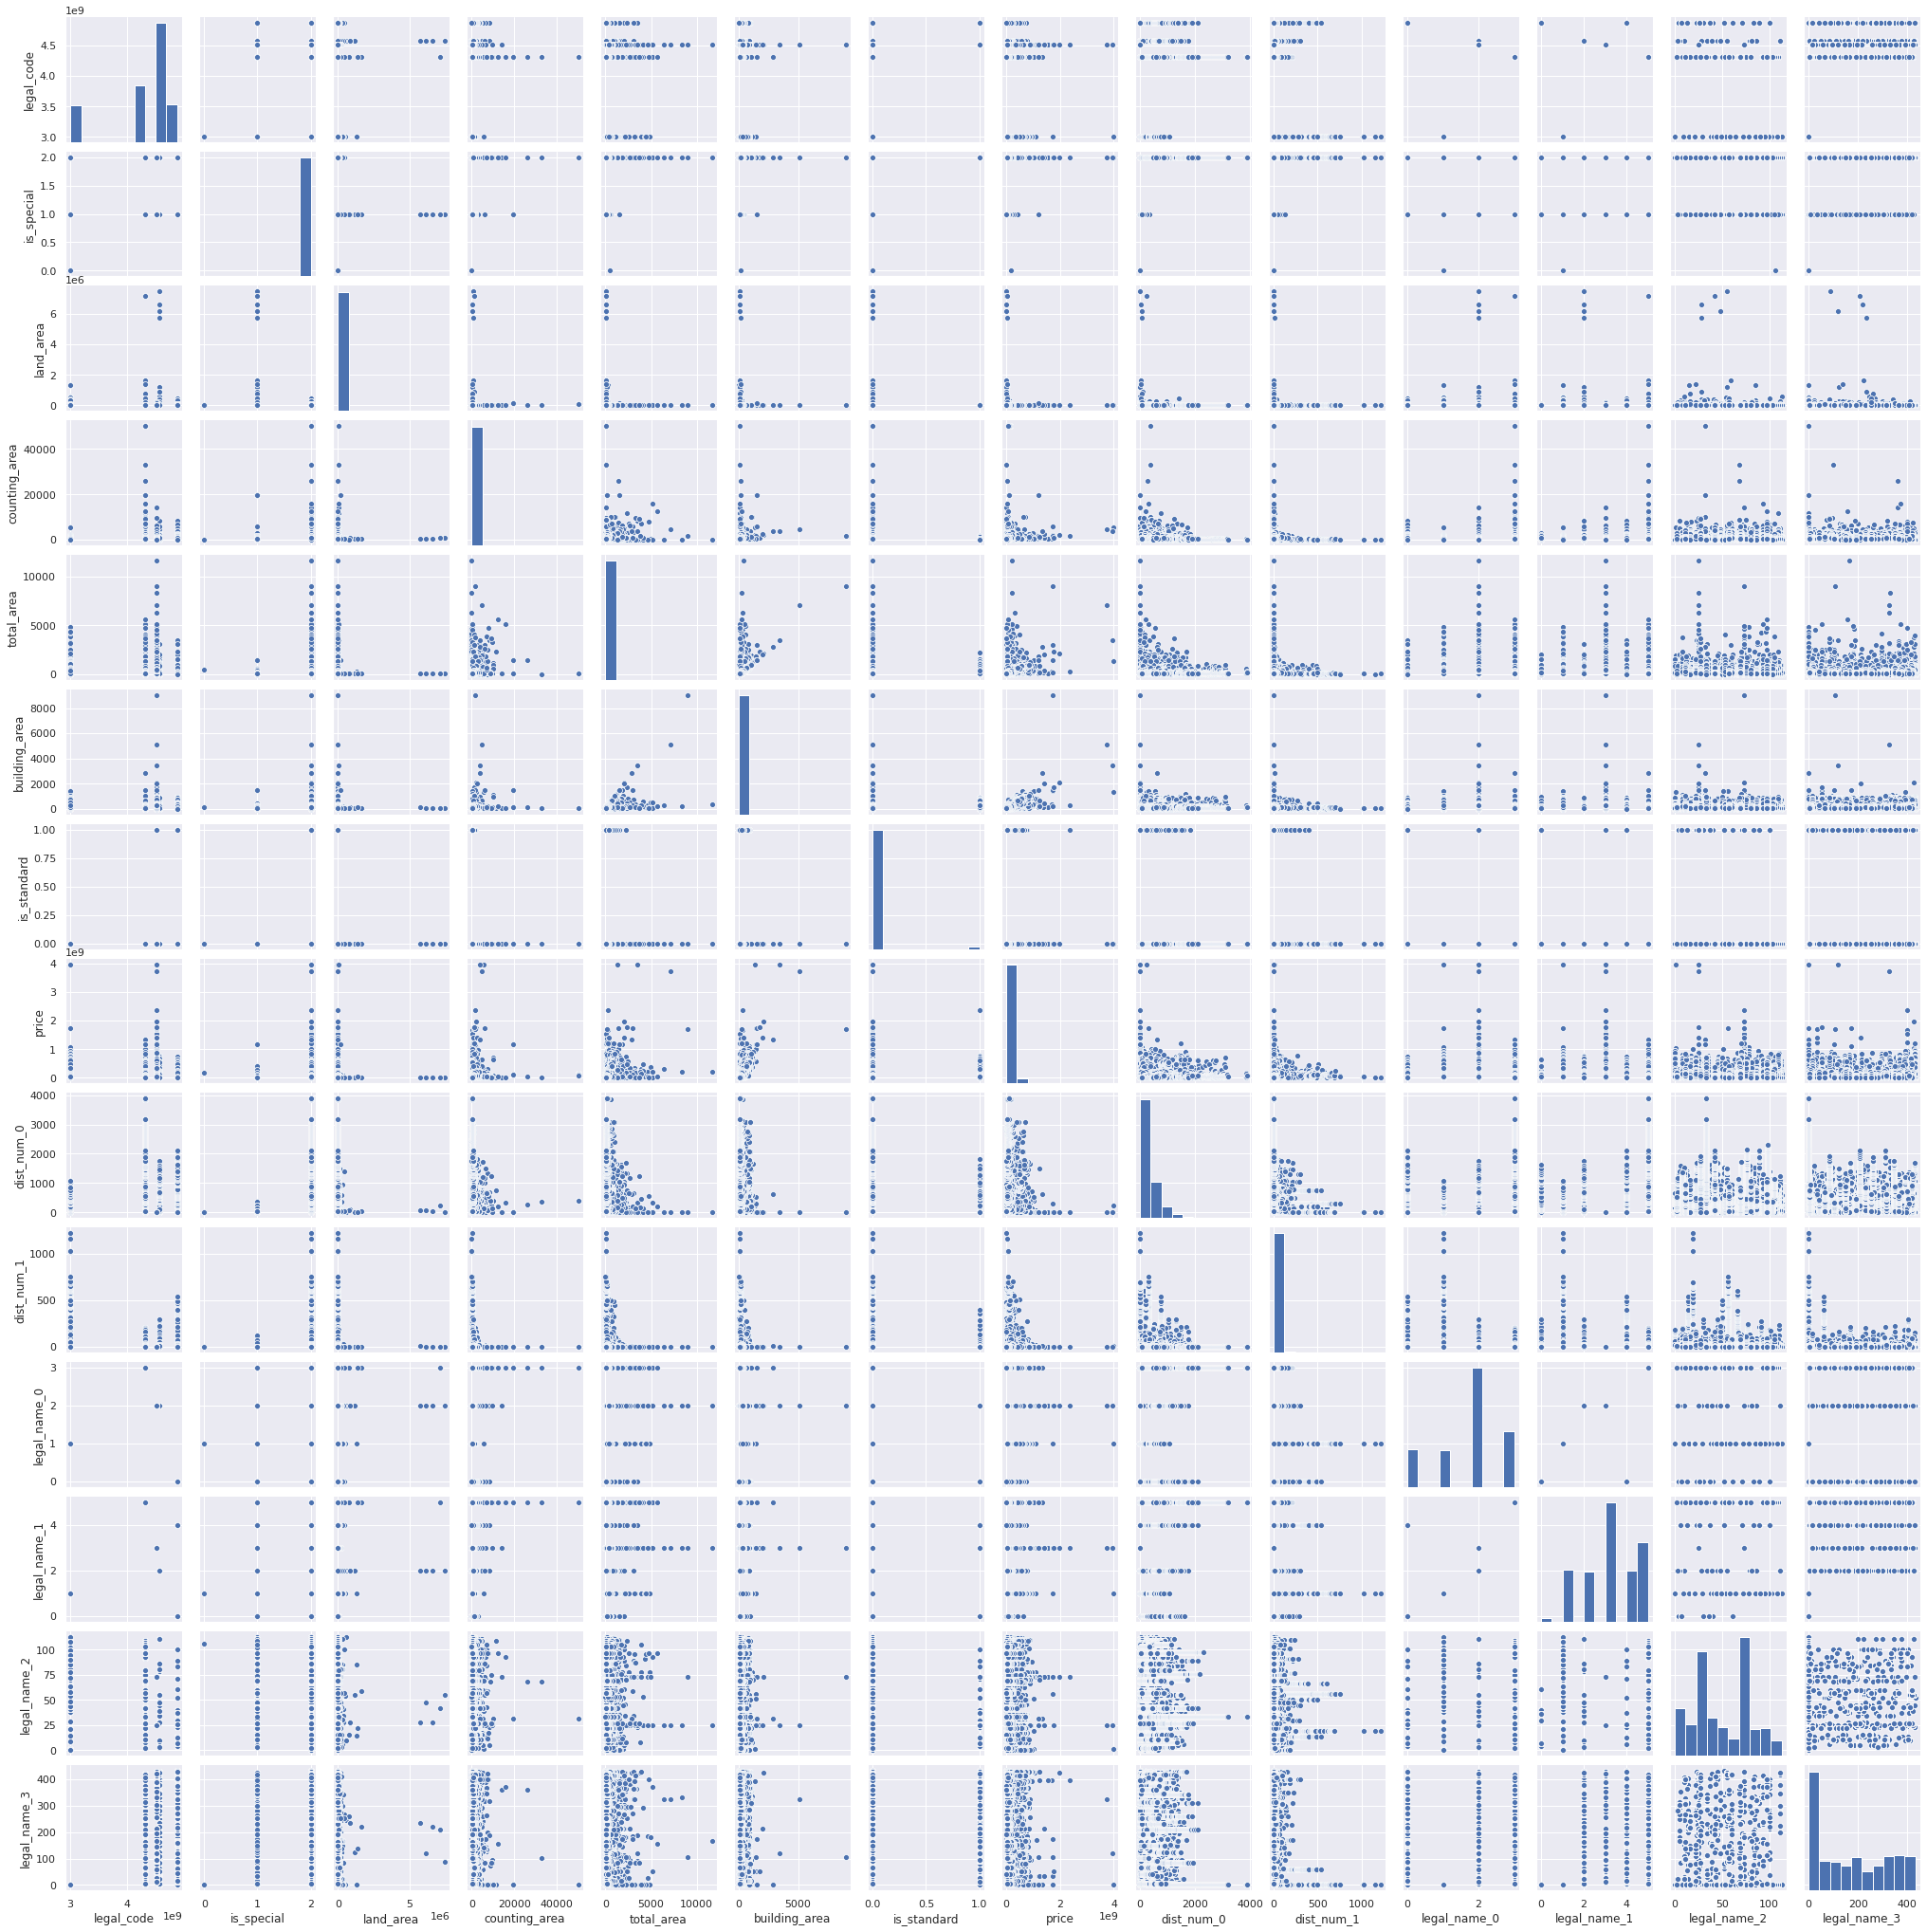

In [17]:
# 코드 3-49 모든 칼럼에 대한 pairplot

sns.set()
sns.pairplot(df_train, height = 2)
plt.show();

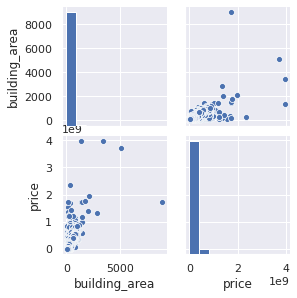

In [18]:
# 3-50 특정 칼럼에 대한 pairplot

sns.set()
sns.pairplot(df_train[['building_area','price']], height = 2)
plt.show();

In [0]:
# 코드 3-51 단위 변환 및 간단한 이상치 제거

df_train['price'] = df_train['price']/100000000
df_inlier = df_train[df_train['building_area']<6000]

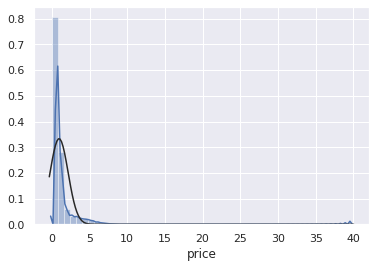

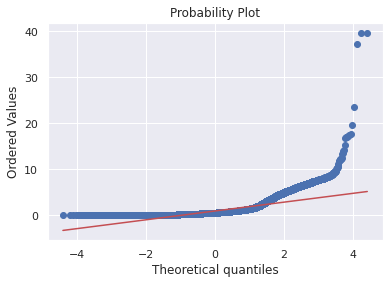

In [20]:
# 코드 3-52 집값 분포 및 Q-Q 그래프 그리기 (로그 변환 전)

sns.distplot(df_train['price'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['price'], plot=plt)

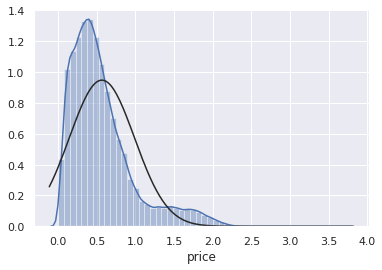

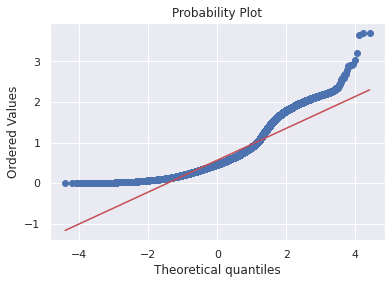

In [21]:
# 코드 3-53 집값 분포 및 Q-Q 그래프 그리기 (로그 변환 후)

sns.distplot(np.log1p(df_train['price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

In [22]:
# 코드 3-54 데이터 전처리, 모델링, 그리고 학습

df_train['price'] = np.log1p(df_train['price'])

X = df_train[df_train.drop('price', axis=1).columns.values]
y = df_train[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2020)

def create_model():
    
    inputs = Input(shape=(13,))
    
    fc1 = Dense(64, activation='tanh',
                kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.01))(inputs)
    dr1 = Dropout(0.5)(fc1)
    fc2 = Dense(128, activation='tanh', 
                kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.01))(dr1)
    dr1 = Dropout(0.3)(fc1)
    outputs = Dense(1, activation='sigmoid')(fc2)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = create_model()
model.summary()
model.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics =[metrics.mae])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________





In [23]:
# 코드 3-55 성능 평가

_eval_1_mse = ((np.expm1(y_test.values) -  np.expm1(model.predict(X_test)))**2).mean()
_eval_1_mae = (np.abs(np.expm1(y_test.values) - np.expm1(model.predict(X_test)))).mean()
_eval_1 = [_eval_1_mse, _eval_1_mae]
print(_eval_1)

[1.4907933295602445, 0.6680397563837218]
